instalaciones e imports previos

In [1]:
pip install tfimm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 687.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 28.6 MB/s eta 0:00:00
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77067 sha256=8b8f0ac92901c470ee334f495fffaeed239233eff5d9e450e7bd8e9f8e0c5c45
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.1
    Uninstalling wrapt-1.14.1:
      Successfully uninstalled wrapt-1.14.1
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
  Attempting uninstall: six
    Found existing installation: six 1.16.0
 

In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tfimm
import timm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [4]:
model_list = tfimm.list_models(pretrained="timm")
str_match = [s for s in model_list if "convmixer" in s]
str_match

['convmixer_768_32', 'convmixer_1024_20_ks9_p14', 'convmixer_1536_20']

In [5]:
convmixer_model = tfimm.create_model("convmixer_768_32", pretrained="timm")
convmixer_model.summary()

2022-06-05 00:39:04.886548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 00:39:04.887636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 00:39:04.888319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 00:39:04.889310: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "conv_mixer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (1, 32, 32, 768)          116736    
_________________________________________________________________
blocks/0 (Block)             multiple                  635136    
_________________________________________________________________
blocks/1 (Block)             multiple                  635136    
_________________________________________________________________
blocks/2 (Block)             multiple                  635136    
_________________________________________________________________
blocks/3 (Block)             multiple                  635136    
_________________________________________________________________
blocks/4 (Block)             multiple                  635136    
_________________________________________________________________
blocks/5 (Block)             multiple                  6

image size de nuestro ConvMixer

In [6]:
image_size = 224

input shape de CIFAR-100

In [7]:
input_shape = (32, 32, 3)

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169017344/169001437 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [9]:
preprocess = tfimm.create_preprocessing("convmixer_768_32", dtype="float32")
x_train, x_test = preprocess(x_train), preprocess(x_test)

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        )
    ],
    name="data_augmentation",
)

añadimos las capas de entrada y salida correspondiente a nuestro problema (CIFAR-100)

In [11]:
inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
features = convmixer_model(augmented)
logits = keras.layers.Dense(100)(features)
model = keras.Model(inputs=inputs, outputs=logits)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
data_augmentation (Sequentia (None, 224, 224, 3)       7         
_________________________________________________________________
conv_mixer (ConvMixer)       (None, 1000)              21210088  
_________________________________________________________________
dense (Dense)                (None, 100)               100100    
Total params: 21,310,195
Trainable params: 21,210,348
Non-trainable params: 99,847
_________________________________________________________________


In [12]:
"""
model = keras.models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(data_augmentation)
for layer in convmixer_model.layers[0:-1]:
    model.add(layer)
model.add(keras.layers.Dense(100))
model.summary()

"""

'\nmodel = keras.models.Sequential()\nmodel.add(layers.Input(shape=input_shape))\nmodel.add(data_augmentation)\nfor layer in convmixer_model.layers[0:-1]:\n    model.add(layer)\nmodel.add(keras.layers.Dense(100))\nmodel.summary()\n\n'

hacemos las capas no entrenables

In [13]:
#for layer in model.layers:
#    layer.trainable = False
#model.summary()

parámetros para compilar, entrenar y evaluar el modelo

In [14]:
learning_rate = 0.00001
weight_decay = 0.0001
batch_size = 32
num_epochs = 10

In [15]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ]
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x= x_train,
        y= y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

history = run_experiment(model)

2022-06-05 00:39:33.417594: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1407/1407 [==============================] - 1811s 1s/step - loss: 4.4404 - accuracy: 0.0510 - top-5-accuracy: 0.1739 - val_loss: 6.2710 - val_accuracy: 0.0850 - val_top-5-accuracy: 0.2382
Epoch 2/10
1407/1407 [==============================] - 1798s 1s/step - loss: 2.8899 - accuracy: 0.2810 - top-5-accuracy: 0.6026 - val_loss: 3.3252 - val_accuracy: 0.3418 - val_top-5-accuracy: 0.6688
Epoch 3/10
1407/1407 [==============================] - 1797s 1s/step - loss: 1.8625 - accuracy: 0.5096 - top-5-accuracy: 0.8263 - val_loss: 1.8731 - val_accuracy: 0.5256 - val_top-5-accuracy: 0.8394
Epoch 4/10
1407/1407 [==============================] - 1796s 1s/step - loss: 1.4633 - accuracy: 0.6212 - top-5-accuracy: 0.8971 - val_loss: 5.1759 - val_accuracy: 0.6256 - val_top-5-accuracy: 0.8932
Epoch 5/10
1407/1407 [==============================] - 1796s 1s/step - loss: 1.2968 - accuracy: 0.6762 - top-5-accuracy: 0.9252 - val_loss: 1.2903 - val_accuracy: 0.6780 - val_top-5-accuracy: 0.9242


# Performance of model

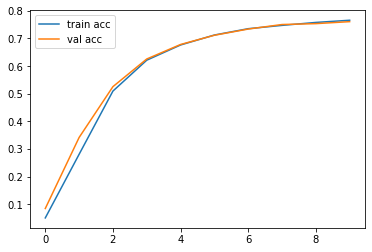

In [16]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

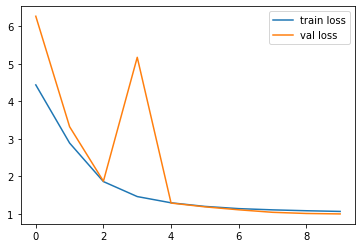

In [17]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()